### Processor
* VOC_duration : 60sec
* Wash_Out : 8min

### Sensors
+ TGS : TGS2600, TGS2602, TGS2603, TGS2610, TGS2620
+ MQ : MQ2, MQ3, MQ4, MQ5, MQ6, MQ7, MQ8, MQ9, MQ135

### VOC
1. DPG ( 10%) + DPG (90%)
2. Actetic (10%) + DPG (90%)
3. Benzaldehyde (10%) + DPG (90%)
4. Keras (10%) + DPG (90%)

In [1]:
%matplotlib inline

from pathlib import Path
from random import randint
import numpy as np
import pandas as pd
from glob import glob
from os.path import isdir
from PIL import Image

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import seaborn as sns

2023-05-19 00:18:26.141693: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 00:18:26.589084: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib64:/usr/local/cuda/lib64:/opt/conda/lib
2023-05-19 00:18:26.589129: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib64:/usr/local/cuda/lib64:/opt/conda/lib
2023-05-

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


2023-05-19 00:18:27.018907: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-19 00:18:27.022333: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-19 00:18:27.022457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
def createDirectory(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print("Error: Failed to create the directory.")

In [4]:
results_path = Path('results', '1min')
if not results_path.exists():
    results_path.mkdir()

In [5]:
data_dir = './data/1min'

labels = {
    0: 'DPG',
    1: 'Acetic',
    2: 'Benzaldehyde',
    3: 'Keras'
}

# categories = ['DW', 'Acetic', 'Benzaldehyde', 'Keras']
num_classes = len(labels)

In [6]:
# Image Size
image_w = 64*3
image_h = 64*3
color = 3

In [7]:
input_shape = image_w, image_h, color
input_shape

(192, 192, 3)

In [8]:
# 펼치기
pixels = image_w * image_h * color
pixels

110592

In [9]:
X = []
y = []
for idx, label in enumerate(labels):
    
#     # One-hot 돌리기
#     label = [0 for i in range(num_classes)]
#     label[idx] = 1
#     print(labels[idx])
    
    image_dir = data_dir + "/" + labels[idx]
    print(image_dir)
    files = glob(image_dir+"_*.png")
#     print(files)
    print(labels[idx], "file length: ", len(files))
    for i, f in enumerate(files):
        img =Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)
        
        X.append(data)
        y.append([label])
#         print(data, label)
        
        if i % 700 == 0:
            print(label, ":", f)

./data/1min/DPG
DPG file length:  182
0 : ./data/1min/DPG_1min_164.png
./data/1min/Acetic
Acetic file length:  182
1 : ./data/1min/Acetic_1min_78.png
./data/1min/Benzaldehyde
Benzaldehyde file length:  181
2 : ./data/1min/Benzaldehyde_1min_44.png
./data/1min/Keras
Keras file length:  181
3 : ./data/1min/Keras_1min_82.png


In [10]:
X = np.array(X)
y = np.array(y)

In [11]:
X.shape

(726, 192, 192, 3)

In [12]:
y.shape

(726, 1)

In [13]:
xy = (X, y)

In [14]:
xy

(array([[[[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         ...,
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
   

In [15]:
# np.save("./data/1min/dataset/1min_data.npy", xy)
# print("ok", len(y))

In [16]:
# X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=24, shuffle=True)

In [17]:
print("The Database has a training set of %d examples." % len(X_train))
print("The Database has a test set of %d examples." % len(X_test))

The Database has a training set of 653 examples.
The Database has a test set of 73 examples.


In [18]:
# xy = (X_train, X_test, y_train, y_test)

In [19]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(653, 192, 192, 3)
(653, 1)
(73, 192, 192, 3)
(73, 1)


In [20]:
# np.save("./data/1min/dataset/1min_data.npy", xy)
# print("ok", len(y))

## Visualize Data

### Visualize First 10 Training Images

The below figure shows the first ten images in the dataset and highlights significant variation among instances of the same digit. On the right, it shows how the pixel values for an indivual image range from 0 to 255.

### Show random image in detail

In [21]:
# plt.imshow(np.squeeze(X_train[0]))

In [22]:
y_train[0, 0]

2

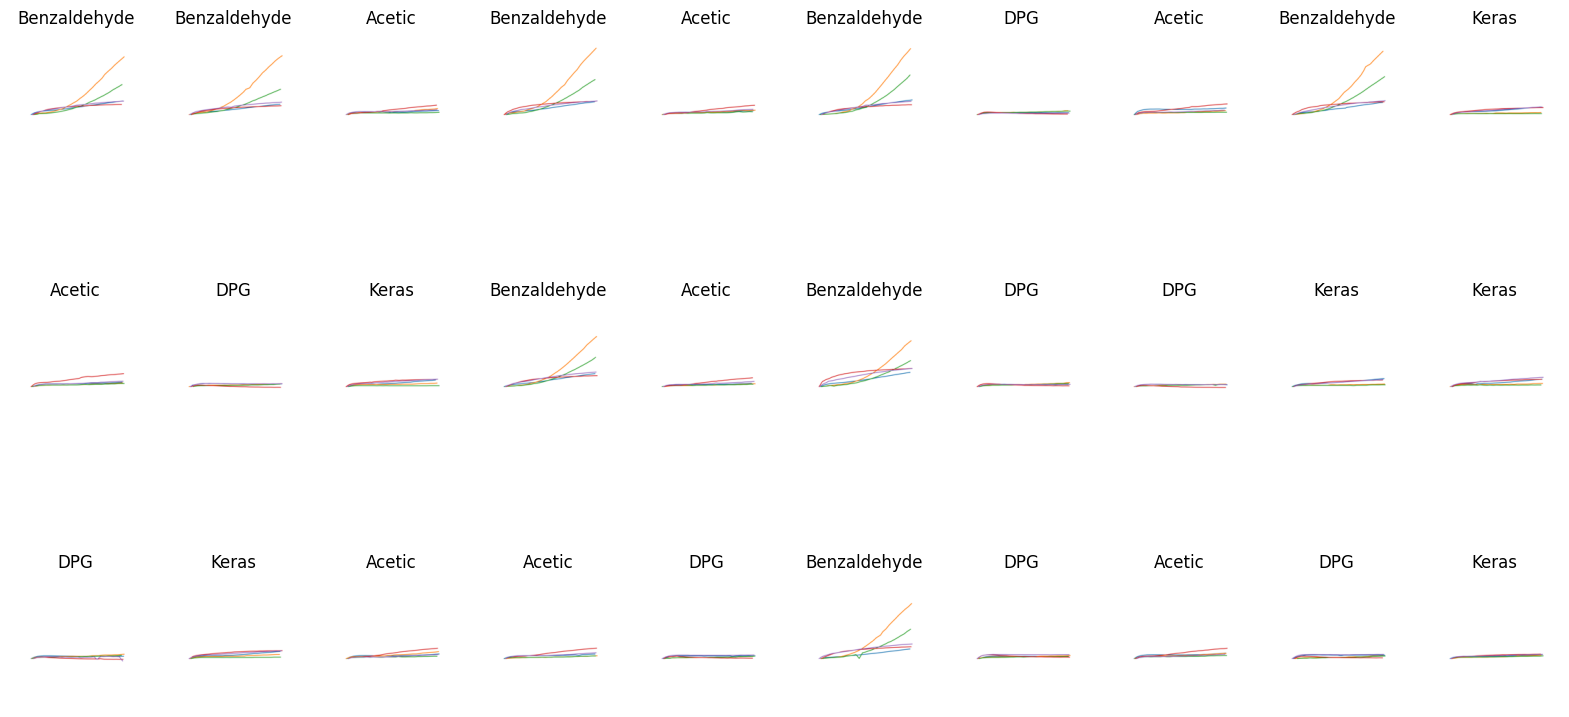

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(20, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(np.squeeze(X_train[i]))
    ax.axis('off')
#     print(y_train[i, 0])
    ax.set_title(labels[y_train[i, 0]])

### Rescale the Images

In [24]:
# rescale [0,255] --> [0,1]
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

### Train-Test split

In [25]:
Split_Num = 80

In [26]:
X_train, X_valid = X_train[Split_Num:], X_train[:Split_Num]
y_train, y_valid = y_train[Split_Num:], y_train[:Split_Num]

In [27]:
# shape of training set
X_train.shape

(573, 192, 192, 3)

In [28]:
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(X_valid.shape[0], 'validation samples')

573 train samples
73 test samples
80 validation samples


## 1) Feedforward Neural Network

### Model Architecture 

In [29]:
mlp = Sequential([
    Flatten(input_shape=input_shape, name='input'),
    Dense(1000, activation='relu', name='hidden_layer_1'),
    Dropout(0.2, name='droput_1'),
    Dense(512, activation='relu', name='hidden_layer_2'),
    Dropout(0.2, name='dropout_2'),
    Dense(num_classes, activation='softmax', name='output')
])

2023-05-19 00:18:38.267082: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 00:18:38.268051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-19 00:18:38.268213: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-19 00:18:38.268316: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [30]:
mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Flatten)             (None, 110592)            0         
                                                                 
 hidden_layer_1 (Dense)      (None, 1000)              110593000 
                                                                 
 droput_1 (Dropout)          (None, 1000)              0         
                                                                 
 hidden_layer_2 (Dense)      (None, 512)               512512    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 output (Dense)              (None, 4)                 2052      
                                                                 
Total params: 111,107,564
Trainable params: 111,107,564


### Compile the Model 

In [31]:
mlp.compile(loss='sparse_categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

### Define Callbacks

In [32]:
mlp_path = (results_path / 'mlp.weights.best.hdf5').as_posix()
mlp_path

'results/1min/mlp.weights.best.hdf5'

In [33]:
checkpointer = ModelCheckpoint(filepath=mlp_path,
                               verbose=1,
                               monitor='val_accuracy',
                               save_best_only=True)

In [34]:
log_path = (results_path / 'logs' / 'mlp').as_posix()
log_path

'results/1min/logs/mlp'

In [35]:
tensorboard = TensorBoard(log_dir=log_path,
                          histogram_freq=1,
                          write_graph=True,
                          write_grads=False,
                          update_freq='epoch')

In [36]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

### Train the Model 

In [37]:
batch_size = 32
epochs = 100

In [38]:
mlp_history = mlp.fit(X_train,
                      y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(X_valid, y_valid),
#                       callbacks=[checkpointer, tensorboard, early_stopping],
                      callbacks=[checkpointer, early_stopping],
                      verbose=1,
                      shuffle=True)

Epoch 1/100


2023-05-19 00:18:39.703184: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-19 00:18:39.705296: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fa6e9310360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-19 00:18:39.705308: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2023-05-19 00:18:39.708059: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-19 00:18:39.783021: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/18 [======================>.......] - ETA: 0s - loss: 119.8687 - accuracy: 0.2634
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to results/1min/mlp.weights.best.hdf5
18/18 [==============================] - 9s 494ms/step - loss: 104.2824 - accuracy: 0.2618 - val_loss: 29.2884 - val_accuracy: 0.2500
Epoch 2/100
13/18 [====================>.........] - ETA: 0s - loss: 21.7753 - accuracy: 0.2236
Epoch 2: val_accuracy did not improve from 0.25000
18/18 [==============================] - 0s 11ms/step - loss: 17.9160 - accuracy: 0.2391 - val_loss: 2.4353 - val_accuracy: 0.2500
Epoch 3/100
14/18 [======================>.......] - ETA: 0s - loss: 2.6174 - accuracy: 0.2790
Epoch 3: val_accuracy did not improve from 0.25000
18/18 [==============================] - 0s 10ms/step - loss: 2.3446 - accuracy: 0.2827 - val_loss: 1.3753 - val_accuracy: 0.2000
Epoch 4/100
15/18 [========================>.....] - ETA: 0s - loss: 1.3864 - accuracy: 0.2438
Epoch 4: val_accuracy did no

### Plot CV Results

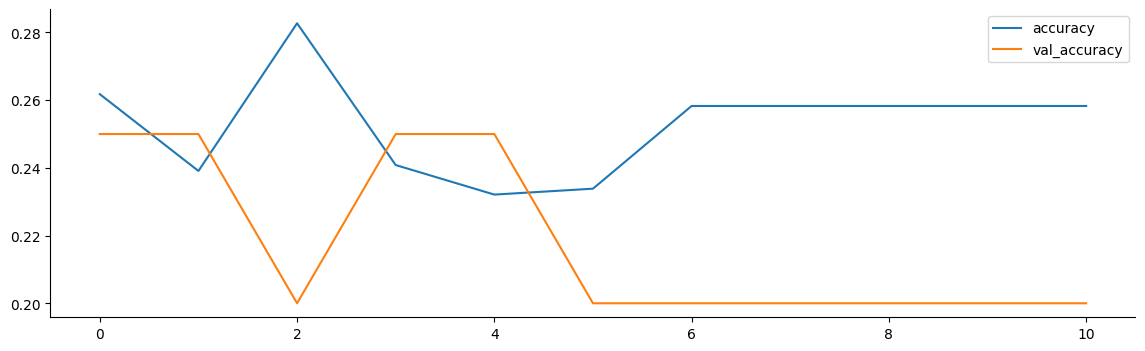

In [39]:
pd.DataFrame(mlp_history.history)[['accuracy', 'val_accuracy']].plot(figsize=(14, 4))
sns.despine()

### Load best model

In [40]:
# load the weights that yielded the best validation accuracy
mlp.load_weights(mlp_path)

### Test Classification Accuracy

In [41]:
# evaluate and print test accuracy
mlp_accuracy = mlp.evaluate(X_test, y_test, verbose=0)[1]
print('Test accuracy: {:.2%}'.format(mlp_accuracy))

Test accuracy: 30.14%


## 2) Convolutional Neural Network

In [42]:
# https://stackoverflow.com/questions/35114376/error-when-computing-summaries-in-tensorflow/35117760#35117760
K.clear_session()

### Model Architecture

In [43]:
cnn = Sequential([
    Conv2D(filters=16,
           kernel_size=2,
           padding='same',
           activation='relu',
           input_shape=input_shape,
           name='CONV1'),
    MaxPooling2D(pool_size=2, name='POOL1'),
    Conv2D(filters=32,
           kernel_size=2,
           padding='same',
           activation='relu',
           name='CONV2'),
    MaxPooling2D(pool_size=2, name='POOL2'),
    Conv2D(filters=64,
           kernel_size=2,
           padding='same',
           activation='relu',
           name='CONV3'),
    MaxPooling2D(pool_size=2, name='POOL3'),
    Dropout(0.3, name='DROP1'),
    Flatten(name='FLAT1'),
    Dense(500, activation='relu', name='FC1'),
    Dropout(0.4, name='DROP2'),
#     Dense(10, activation='softmax', name='FC2')
    Dense(num_classes, activation='softmax', name='FC2')
])

In [44]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv2D)              (None, 192, 192, 16)      208       
                                                                 
 POOL1 (MaxPooling2D)        (None, 96, 96, 16)        0         
                                                                 
 CONV2 (Conv2D)              (None, 96, 96, 32)        2080      
                                                                 
 POOL2 (MaxPooling2D)        (None, 48, 48, 32)        0         
                                                                 
 CONV3 (Conv2D)              (None, 48, 48, 64)        8256      
                                                                 
 POOL3 (MaxPooling2D)        (None, 24, 24, 64)        0         
                                                                 
 DROP1 (Dropout)             (None, 24, 24, 64)        0

### Compile the Model

In [45]:
cnn.compile(loss='sparse_categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

### Define Callbacks

In [46]:
cnn_path = (results_path / 'cnn.weights.best.hdf5').as_posix()

In [47]:
checkpointer = ModelCheckpoint(filepath=cnn_path,
                               verbose=1,
                               monitor='val_accuracy',
                               save_best_only=True)

In [48]:
tensorboard = TensorBoard(log_dir=results_path / 'logs' / 'cnn',
                          histogram_freq=1,
                          write_graph=True,
                          write_grads=False,
                          update_freq='epoch')

In [49]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

### Train the Model

In [50]:
batch_size = 32
epochs = 100

In [51]:
cnn_history = cnn.fit(X_train,
                      y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(X_valid, y_valid),
#                       callbacks=[checkpointer, tensorboard, early_stopping],
                      callbacks=[checkpointer, early_stopping],
                      verbose=2,
                      shuffle=True)

Epoch 1/100


2023-05-19 00:18:51.464461: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/DROP1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-19 00:18:51.816239: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101



Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to results/1min/cnn.weights.best.hdf5
18/18 - 4s - loss: 2.1975 - accuracy: 0.2740 - val_loss: 1.3726 - val_accuracy: 0.2500 - 4s/epoch - 198ms/step
Epoch 2/100

Epoch 2: val_accuracy improved from 0.25000 to 0.66250, saving model to results/1min/cnn.weights.best.hdf5
18/18 - 2s - loss: 1.3034 - accuracy: 0.4049 - val_loss: 1.1282 - val_accuracy: 0.6625 - 2s/epoch - 84ms/step
Epoch 3/100

Epoch 3: val_accuracy improved from 0.66250 to 0.73750, saving model to results/1min/cnn.weights.best.hdf5
18/18 - 2s - loss: 0.8657 - accuracy: 0.6422 - val_loss: 0.6929 - val_accuracy: 0.7375 - 2s/epoch - 84ms/step
Epoch 4/100

Epoch 4: val_accuracy improved from 0.73750 to 0.88750, saving model to results/1min/cnn.weights.best.hdf5
18/18 - 2s - loss: 0.4544 - accuracy: 0.8045 - val_loss: 0.3431 - val_accuracy: 0.8875 - 2s/epoch - 86ms/step
Epoch 5/100

Epoch 5: val_accuracy improved from 0.88750 to 0.91250, saving model to results/1

### Plot CV Results

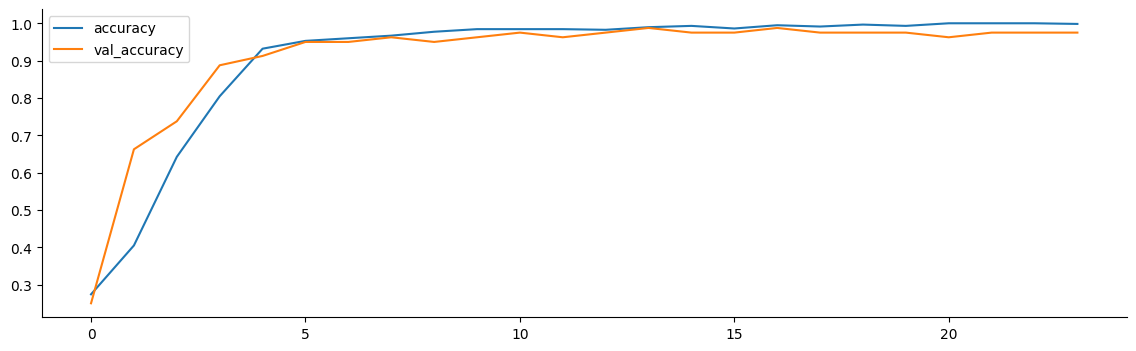

In [52]:
pd.DataFrame(cnn_history.history)[['accuracy',
                                   'val_accuracy']].plot(figsize=(14, 4))
sns.despine();

### Load best model

In [53]:
cnn.load_weights(cnn_path)

### Test set accuracy

In [54]:
cnn_accuracy = cnn.evaluate(X_test, y_test, verbose=0)[1]
print('Accuracy: {:.2%}'.format(cnn_accuracy))

Accuracy: 97.26%


### Evaluate Predictions

In [55]:
y_hat = cnn.predict(X_test)

3/3 [==============================] - 0s 2ms/step


In [56]:
# y_hat
print(np.argmax(y_test[0]), np.argmax(y_hat[0]))


0 3


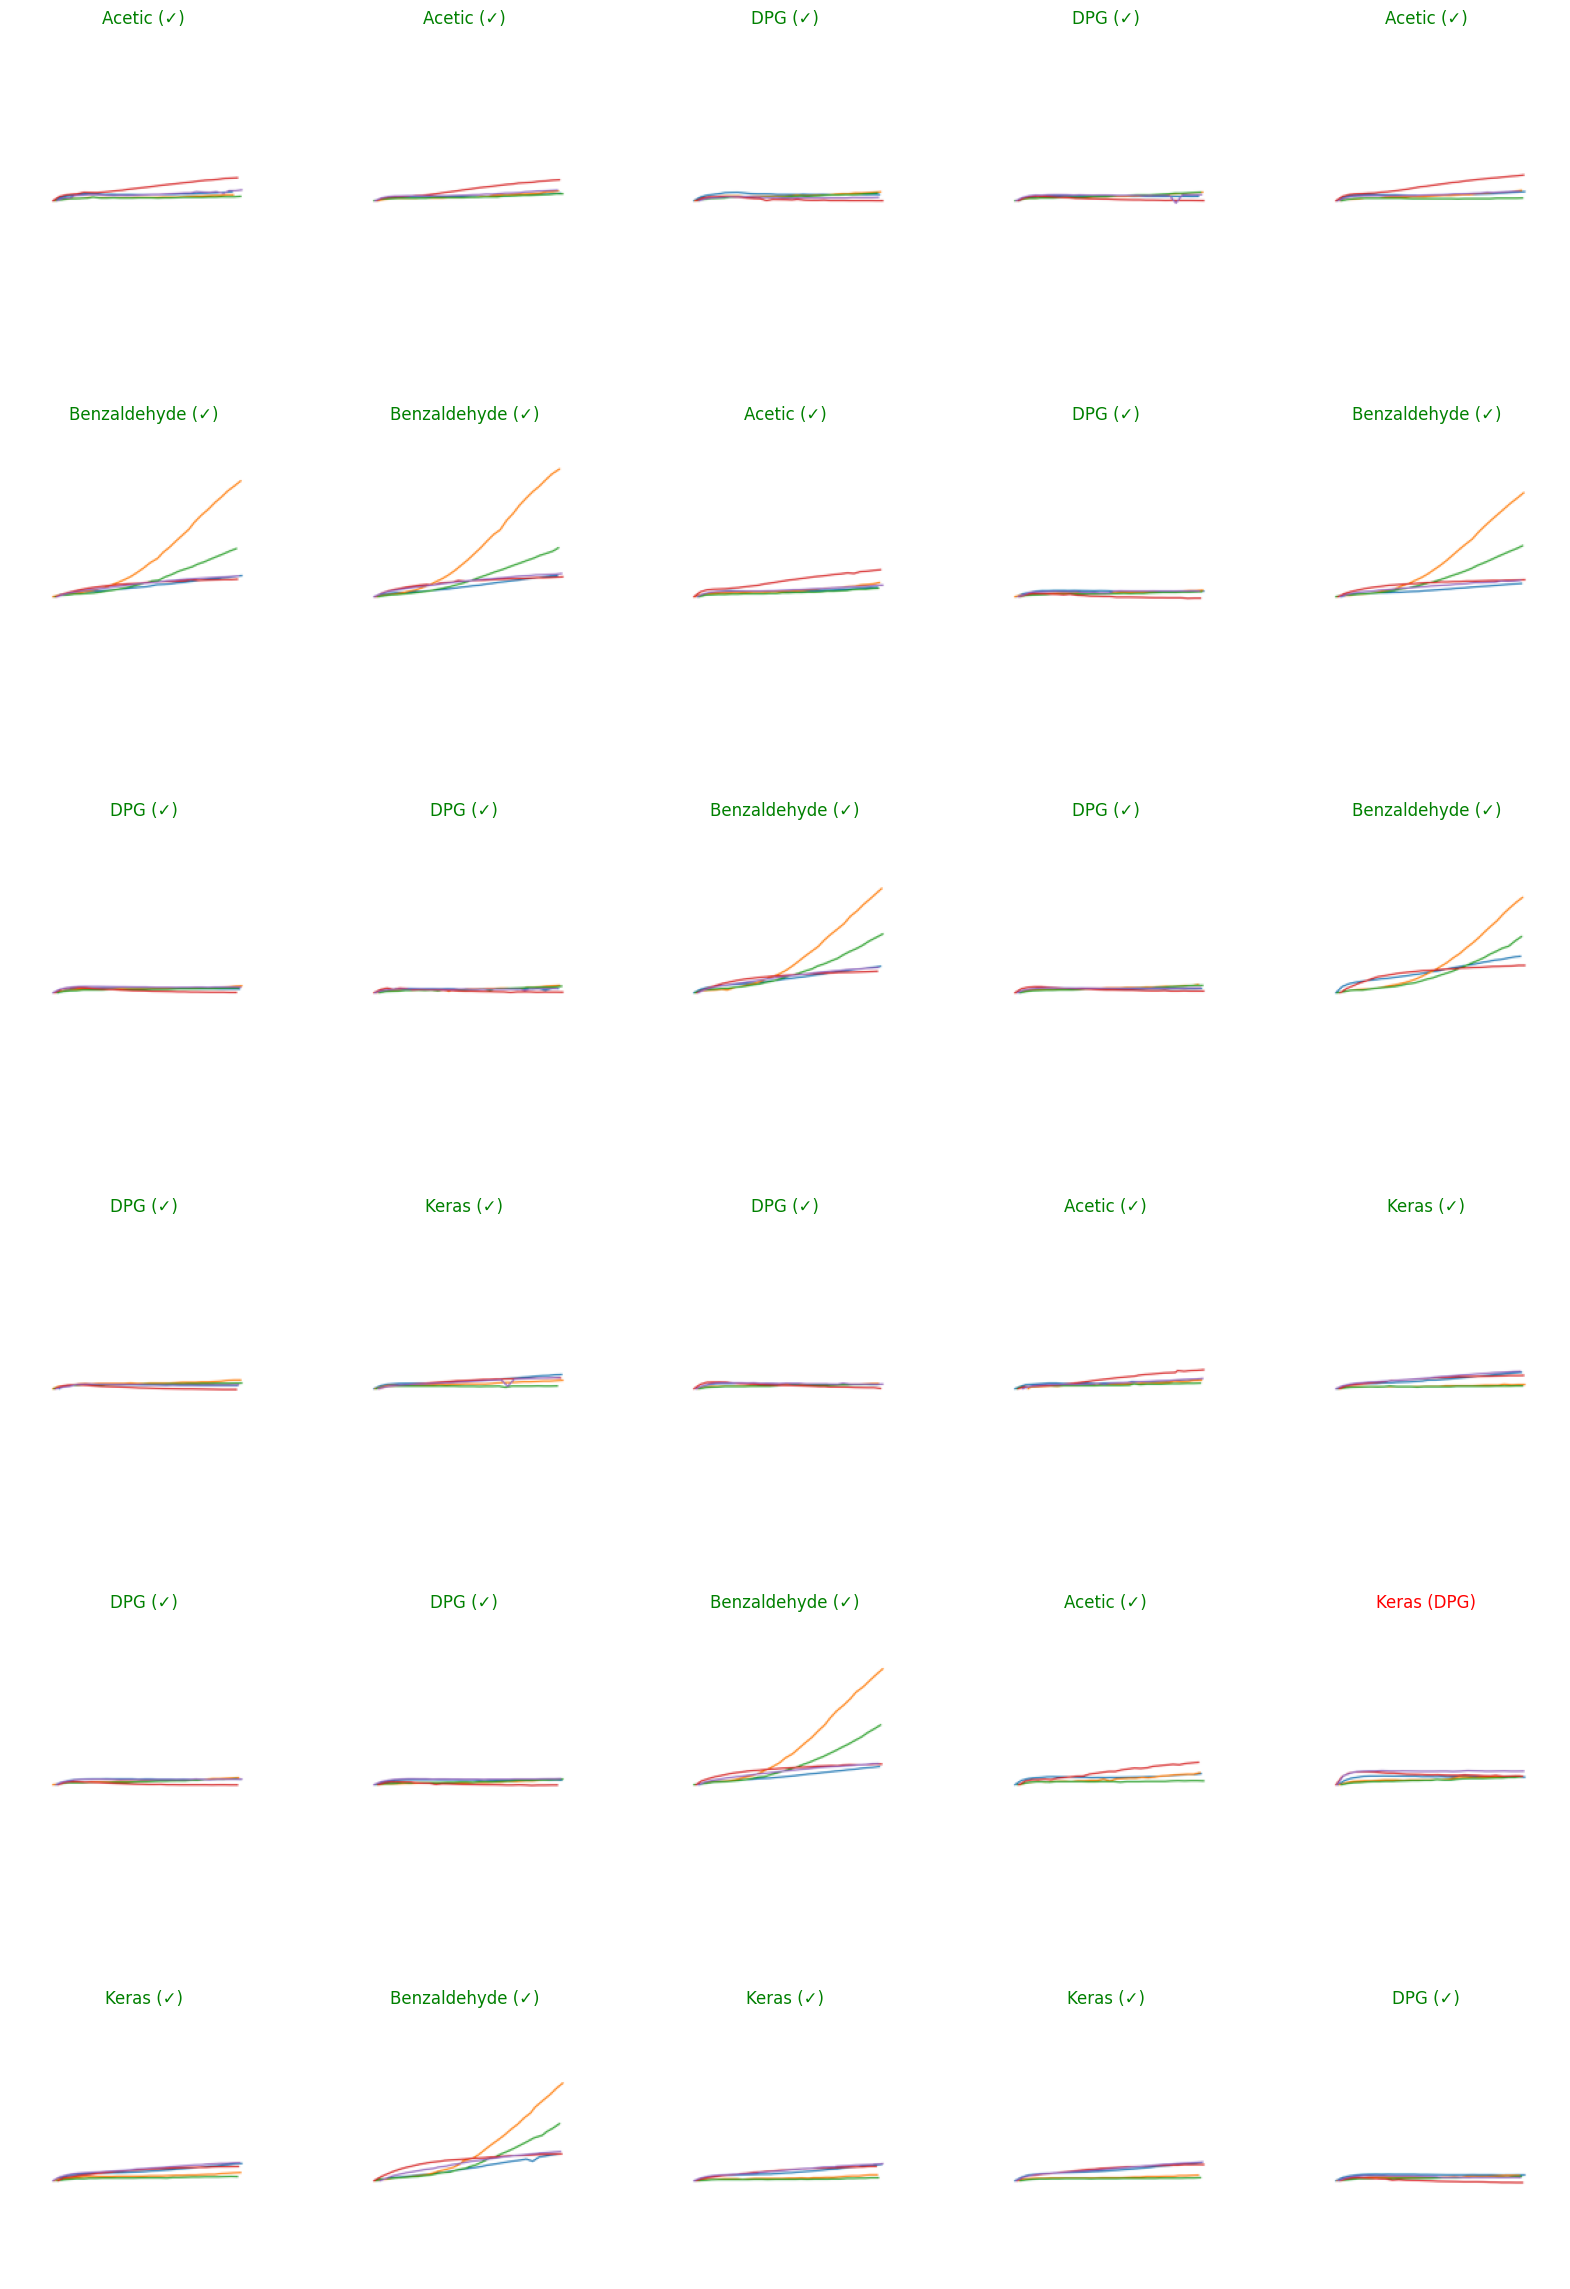

In [57]:
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(20, 30))
axes = axes.flatten()
images = np.random.choice(X_test.shape[0], size=30, replace=False)
for i, (ax, idx) in enumerate(zip(axes, images)):
    ax.imshow(np.squeeze(X_test[idx]))
    ax.axis('off')
#     pred_idx, true_idx = np.argmax(y_hat[idx]), np.argmax(y_test[idx])
#     pred_idx, true_idx = np.argmax(y_hat[idx]), np.argmax(y_test[idx, 0])
    pred_idx, true_idx = np.argmax(y_hat[idx]), y_test[idx, 0]
#     print(pred_idx, true_idx)
    if pred_idx == true_idx:
        ax.set_title('{} (✓)'.format(labels[pred_idx]), color="green")
    else:
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]), color='red')

## AlexNet

We also need to simplify the AlexNet architecture in response to the lower dimensionality of CIFAR10 images relative to the ImageNet samples used in the competition. We use the original number of filters but make them smaller (see notebook for implementation). The summary shows the five convolutional layers followed by two fully-connected layers with frequent use of batch normalization, for a total of 21.5 million parameters:

### Define Architecture

In [58]:
K.clear_session()

In [59]:
alexnet = Sequential([

    # 1st Convolutional Layer
    Conv2D(96, (3, 3),
           strides=(2, 2),
           activation='relu',
           padding='same',
           input_shape=input_shape,
           name='CONV_1'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='POOL_1'),
    BatchNormalization(name='NORM_1'),

    # 2nd Convolutional Layer
    Conv2D(filters=256,
           kernel_size=(5, 5),
           padding='same',
           activation='relu',
           name='CONV2'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='POOL2'),
    BatchNormalization(name='NORM_2'),

    # 3rd Convolutional Layer
    Conv2D(filters=384,
           kernel_size=(3, 3),
           padding='same',
           activation='relu',
           name='CONV3'),
    # 4th Convolutional Layer
    Conv2D(filters=384,
           kernel_size=(3, 3),
           padding='same',
           activation='relu',
           name='CONV4'),
    # 5th Convolutional Layer
    Conv2D(filters=256,
           kernel_size=(3, 3),
           padding='same',
           activation='relu',
           name='CONV5'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='POOL5'),
    BatchNormalization(name='NORM_5'),

    # Fully Connected Layers
    Flatten(name='FLAT'),
    Dense(4096, input_shape=(32 * 32 * 3, ), activation='relu', name='FC1'),
    Dropout(0.4, name='DROP1'),
    Dense(4096, activation='relu', name='FC2'),
    Dropout(0.4, name='DROP2'),
    Dense(num_classes, activation='softmax')
])

In [60]:
alexnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV_1 (Conv2D)             (None, 96, 96, 96)        2688      
                                                                 
 POOL_1 (MaxPooling2D)       (None, 48, 48, 96)        0         
                                                                 
 NORM_1 (BatchNormalization)  (None, 48, 48, 96)       384       
                                                                 
 CONV2 (Conv2D)              (None, 48, 48, 256)       614656    
                                                                 
 POOL2 (MaxPooling2D)        (None, 23, 23, 256)       0         
                                                                 
 NORM_2 (BatchNormalization)  (None, 23, 23, 256)      1024      
                                                                 
 CONV3 (Conv2D)              (None, 23, 23, 384)       8

### Compile Model

In [61]:
alexnet.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

### Define Callbacks

In [62]:
alexnet_path = (results_path / 'alexnet.weights.best.hdf5').as_posix()

In [63]:
checkpointer = ModelCheckpoint(filepath=alexnet_path,
                               verbose=1,
                               monitor='val_accuracy',
                               save_best_only=True)

In [64]:
tensorboard = TensorBoard(log_dir=results_path / 'logs' / 'alexnet',
                          histogram_freq=1,
                          write_graph=True,
                          write_grads=False,
                          update_freq='epoch')

In [65]:
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               mode='max',
                               patience=10)

### Train Model

In [66]:
batch_size = 32
epochs = 100

In [67]:
alex_history = alexnet.fit(X_train, 
                           y_train,
                           batch_size=batch_size,
                           epochs=epochs,
                           validation_data=(X_valid, 
                                            y_valid),
                           callbacks=[checkpointer, 
#                                       tensorboard, 
                                      early_stopping],
                           verbose=1)

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 50.2776 - accuracy: 0.4398
Epoch 1: val_accuracy improved from -inf to 0.20000, saving model to results/1min/alexnet.weights.best.hdf5
18/18 [==============================] - 5s 160ms/step - loss: 50.2776 - accuracy: 0.4398 - val_loss: 3019.6387 - val_accuracy: 0.2000
Epoch 2/100
16/18 [=========================>....] - ETA: 0s - loss: 1.6390 - accuracy: 0.6953
Epoch 2: val_accuracy did not improve from 0.20000
18/18 [==============================] - 0s 27ms/step - loss: 1.5856 - accuracy: 0.6998 - val_loss: 2272.3521 - val_accuracy: 0.2000
Epoch 3/100
17/18 [===========================>..] - ETA: 0s - loss: 0.5641 - accuracy: 0.8070
Epoch 3: val_accuracy did not improve from 0.20000
18/18 [==============================] - 0s 27ms/step - loss: 0.5470 - accuracy: 0.8133 - val_loss: 1542.0704 - val_accuracy: 0.2000
Epoch 4/100
17/18 [===========================>..] - ETA: 0s - loss: 0.3071 - accuracy: 0.8915
Epoch 4:

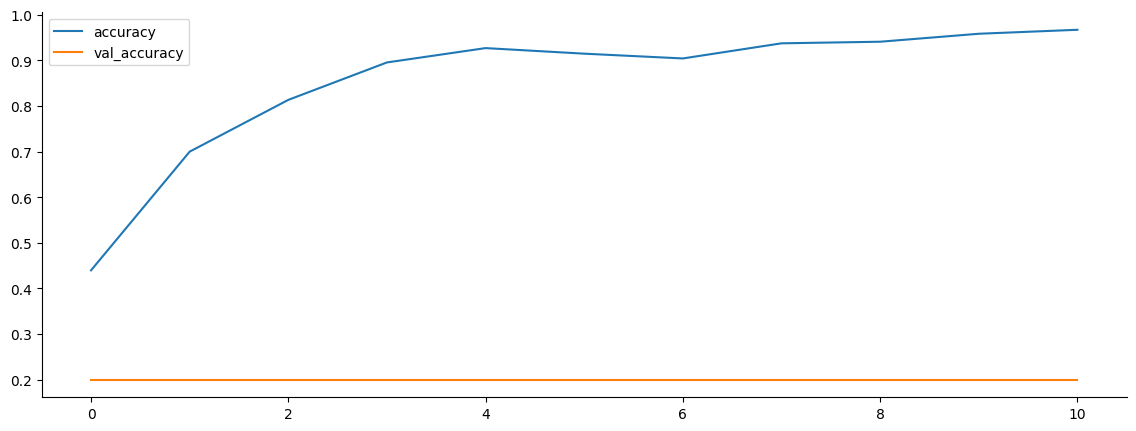

In [68]:
pd.DataFrame(alex_history.history)[['accuracy', 'val_accuracy']].plot(figsize=(14, 5))
sns.despine();

In [69]:
alexnet.load_weights(alexnet_path)

In [70]:
alex_accuracy = alexnet.evaluate(X_test, y_test, verbose=0)[1]
print('Test Accuracy: {:.2%}'.format(alex_accuracy))

Test Accuracy: 23.29%


## Compare Results

In [71]:
cv_results = pd.DataFrame(
    {'Feed-Forward NN': pd.Series(mlp_history.history['val_accuracy']),
        'CNN': pd.Series(cnn_history.history['val_accuracy']),
        'Alex Net': pd.Series(alex_history.history['val_accuracy'])
    })

In [72]:
test_accuracy = pd.Series({
    'Feed-Forward NN': mlp_accuracy,
    'CNN': cnn_accuracy,
    'Alex Net': alex_accuracy
})

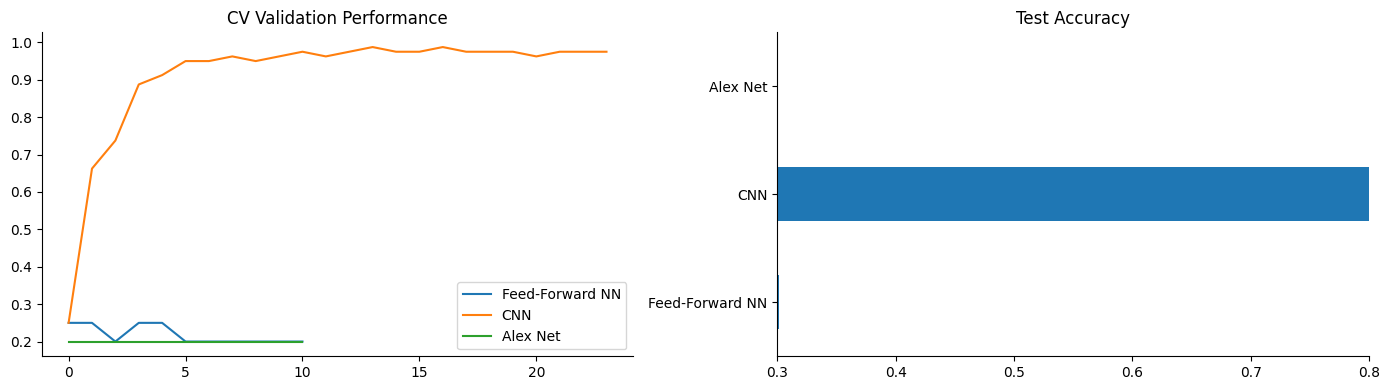

In [73]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
cv_results.plot(ax=axes[0], title='CV Validation Performance')
test_accuracy.plot.barh(ax=axes[1], xlim=(.3, .8), title='Test Accuracy')
fig.tight_layout()
sns.despine()
fig.savefig(results_path / 'comparison', dpi=300);